In [17]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import numpy as np

PV = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/seobu_pv.csv'
pv_source = pd.read_csv(PV, encoding='CP949')
pv_source = pd.DataFrame(pv_source)
pv_source = pv_source.iloc[0:1277, :]
pv_data = np.array(pv_source)

weather_17 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2017.csv'
weather_18 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2018.csv'
weather_19 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2019.csv'
weather_20 = 'C:/Users/Smartgrid_ML/Documents/KMS/btm_data/korean_data/pv/mokpo_2020.csv'

weather_17 = pd.read_csv(weather_17, encoding='CP949')
weather_18 = pd.read_csv(weather_18, encoding='CP949')
weather_19 = pd.read_csv(weather_19, encoding='CP949')
weather_20 = pd.read_csv(weather_20, encoding='CP949')
weather = pd.concat([weather_17,weather_18,weather_19,weather_20])
weather_data = np.array(weather)

pv_data = np.nan_to_num(pv_data)
weather_data = np.nan_to_num(weather_data)
pv_dat = pv_data[:, 2:]
weather_dat = weather_data[:, 3:]
pv_dat = pv_dat.reshape(-1,1)

dataset = np.hstack([pv_dat, weather_dat])
index = ['Measured PV', 'Temperature C', 'Rainfall', 'Wind speed', 'Wind direction', 'Humidity', 'Air pressure', 'Dew point C', 'Sunshine', 'Solar radiation', 'Snowfall', 'Cloud cover', 'Surface temp C']

df = pd.DataFrame(dataset, columns=index)
df.head()
df = df.fillna(0)
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [18]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 4, 5, 6, 8, 9, 11, 12)]
print(norm_df2.shape)

(30648, 9)


In [19]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [20]:
timesteps = 24
output_timesteps = 12

X, Y = create_dataset(norm_df2, timesteps, output_timesteps)

trX = X[:18389, :, :]
vaX = X[18389:21453, :, :]
teX = X[21453:, :, :]
trY = Y[:18389, :, 0]
vaY = Y[18389:21453, :, 0]
teY = Y[21453:, :, 0]

print(trX.shape)
print(trY.shape)
print(teX.shape)

(18389, 24, 9)
(18389, 12)
(9158, 24, 9)


In [21]:
with tf.device('/gpu:0'):
    alpha=0.5
    beta = math.sqrt(2/alpha)
    num_features = 9
    hfilters = 256
    hkernel_size1 = 16
    hkernel_size2 = 32
    visible1 = Input(shape=(24, num_features))
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(visible1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res10 = Add()([d1, res09])   # (100, 25) (100, 25)
    out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # --------------------  
    out = Dropout(0.2)(out)   
    out = Conv1D(256, 1, padding='same', activation='relu')(out) # 1 is 1x1 conv, same is normal conv.  
    out = Dropout(0.2)(out)  
    out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1
    out = Dense(output_timesteps)(out) 
    model = Model(inputs=[visible1], outputs=[out])
    
    print(model.summary())
    
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=150)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()

    hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 24, 128)      36992       input_2[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 24, 128)      0           conv1d_22[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 24, 128)      0           conv1d_22[0][0]                  
____________________________________________________________________________________________

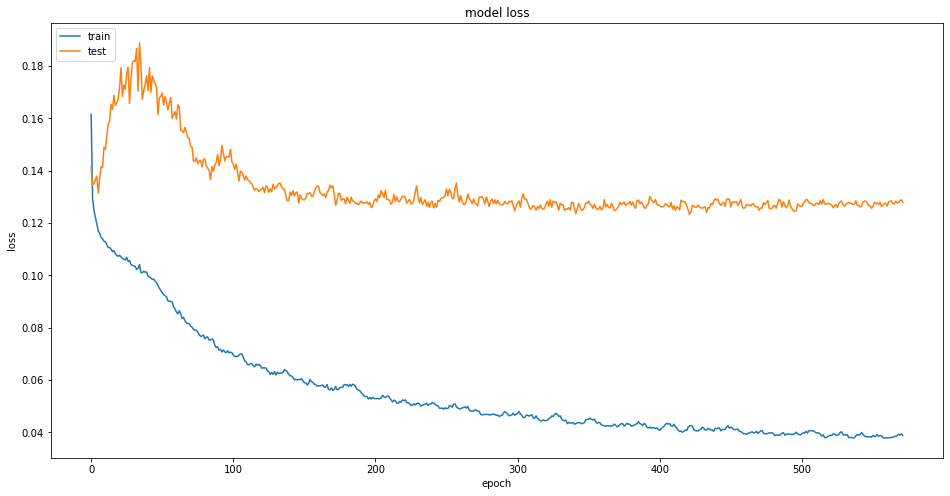

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('EFF_Model_TrainingandValidation Loss.png')
#print(get_flops(model))

In [23]:
trainPredict = model.predict(trX, batch_size=batch_size)
validPredict = model.predict(vaX, batch_size=batch_size)
testPredict = model.predict(teX, batch_size=batch_size)
tePredict = testPredict.reshape([-1])
testY = teY.reshape([-1])

np.savetxt('Alpha0.5_EFFmodel_testPredict.txt', tePredict)
 
print(tePredict.shape)
print(testY.shape)

(109896,)
(109896,)


In [24]:
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(testY-tePredict))), ' MAE == ', mean_absolute_error(testY, tePredict), 'MAPE == ', mean_absolute_percentage_error(testY, tePredict))

Error Test Score > RMSE ==  0.11657756695752687  MAE ==  0.06385625353117858 MAPE ==  inf


C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide


In [25]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(21453, 12)
(21453, 12)


In [40]:
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df.head()

,Measured PV,Temperature C,Rainfall,Wind speed,Wind direction,Humidity,Air pressure,Dew point C,Sunshine,Solar radiation,Snowfall,Cloud cover,Surface temp C
0,0.0,0.354298,0.0,0.023256,0.000000,0.89,0.189696,0.444681,0.0,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.0,0.104651,0.444444,0.93,0.189696,0.442553,0.0,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.0,0.046512,0.388889,0.93,0.177986,0.423404,0.0,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.0,0.087209,0.444444,0.94,0.170960,0.410638,0.0,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.0,0.104651,0.444444,0.95,0.161593,0.395745,0.0,0.0,0.0,0.0,0.088825


In [41]:
norm_df2 = norm_df.iloc[:21453,[0, 1, 4, 5, 6, 8, 9, 11, 12]]
norm_df2.head()

,Measured PV,Temperature C,Wind direction,Humidity,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C
0,0.0,0.354298,0.000000,0.89,0.189696,0.0,0.0,0.6,0.141834
1,0.0,0.339623,0.444444,0.93,0.189696,0.0,0.0,0.0,0.117479
2,0.0,0.320755,0.388889,0.93,0.177986,0.0,0.0,0.0,0.103152
3,0.0,0.303983,0.444444,0.94,0.170960,0.0,0.0,0.0,0.095989
4,0.0,0.287212,0.444444,0.95,0.161593,0.0,0.0,0.0,0.088825


In [42]:
Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12']

pr_df = pd.DataFrame(prediction, columns=Prindex)
pr_df.head()

,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9,Prediction10,Prediction11,Prediction12
0,0.003877,0.006102,0.006416,0.001568,0.000105,-0.007294,-0.013549,-0.001916,0.081897,0.273196,0.487391,0.593934
1,0.008607,0.005574,0.006761,0.000786,-0.006697,-0.018884,-0.011393,0.064117,0.234325,0.455456,0.615402,0.646971
2,0.003349,0.001189,-0.001648,-0.015779,-0.023569,-0.011423,0.061559,0.229116,0.446071,0.595679,0.640389,0.610677
3,0.015093,0.004251,-0.000419,-0.016794,-0.025581,0.036894,0.241826,0.473302,0.612154,0.659197,0.628301,0.505590
4,0.010444,-0.001051,-0.010810,-0.025853,0.009735,0.158375,0.420067,0.639031,0.707779,0.642630,0.516647,0.360713


In [43]:
er_df = pd.DataFrame(errors, columns=Erindex)
er_df.head()

,Error1,Error2,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.003877,0.006102,0.006416,0.001568,0.000105,-0.007294,-0.013549,-0.001916,0.053990,0.115831,-0.014160,0.001686
1,0.008607,0.005574,0.006761,0.000786,-0.006697,-0.018884,-0.011393,0.036210,0.076960,-0.046094,0.023154,-0.025898
2,0.003349,0.001189,-0.001648,-0.015779,-0.023569,-0.011423,0.033652,0.071752,-0.055479,0.003431,-0.032479,0.022305
3,0.015093,0.004251,-0.000419,-0.016794,-0.025581,0.008987,0.084462,-0.028248,0.019906,-0.013671,0.039928,-0.007589
4,0.010444,-0.001051,-0.010810,-0.025853,-0.018172,0.001010,-0.081483,0.046783,0.034911,0.054257,0.003469,-0.003628


In [44]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2.head()

,Measured PV,Temperature C,Wind direction,Humidity,Air pressure,Sunshine,Solar radiation,Cloud cover,Surface temp C,Prediction1,...,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.0,0.354298,0.000000,0.89,0.189696,0.0,0.0,0.6,0.141834,0.003877,...,0.006416,0.001568,0.000105,-0.007294,-0.013549,-0.001916,0.053990,0.115831,-0.014160,0.001686
1,0.0,0.339623,0.444444,0.93,0.189696,0.0,0.0,0.0,0.117479,0.008607,...,0.006761,0.000786,-0.006697,-0.018884,-0.011393,0.036210,0.076960,-0.046094,0.023154,-0.025898
2,0.0,0.320755,0.388889,0.93,0.177986,0.0,0.0,0.0,0.103152,0.003349,...,-0.001648,-0.015779,-0.023569,-0.011423,0.033652,0.071752,-0.055479,0.003431,-0.032479,0.022305
3,0.0,0.303983,0.444444,0.94,0.170960,0.0,0.0,0.0,0.095989,0.015093,...,-0.000419,-0.016794,-0.025581,0.008987,0.084462,-0.028248,0.019906,-0.013671,0.039928,-0.007589
4,0.0,0.287212,0.444444,0.95,0.161593,0.0,0.0,0.0,0.088825,0.010444,...,-0.010810,-0.025853,-0.018172,0.001010,-0.081483,0.046783,0.034911,0.054257,0.003469,-0.003628


In [45]:
norm_df2 = norm_df2.iloc[:,[1,2,4,5,6,7,8,9,10,11,18,20,21,22,23,24,25,26,27,28,29,30,31,32]]

In [46]:
norm_df2 = np.array(norm_df2)
timesteps = 24
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
print(Xe.shape)
print(Ye.shape)

(21427, 24, 24)
(21427, 1, 24)


In [48]:
trXe = Xe[:19000, :, :]
vaXe = Xe[19000:, :, :]
trYe = Ye[:19000, :, 12:]
vaYe = Ye[19000:, :, 12:]
trYe = trYe.reshape(-1,12)
vaYe = vaYe.reshape(-1,12)
print(trXe.shape)
print(trYe.shape)
print(vaXe.shape)

(19000, 24, 24)
(19000, 12)
(2427, 24, 24)


In [49]:
with tf.device('/gpu:0'):
    alpha=0.5
    beta = math.sqrt(2/alpha)
    num_features = 24
    hfilters = 256
    hkernel_size1 = 16
    hkernel_size2 = 32
    visible1e = Input(shape=(24, num_features))
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(visible1e)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1e])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res10 = Add()([d1, res09])   # (100, 25) (100, 25)
    oute = Conv1D(512, 1, padding='same', activation='relu')(res10)   # --------------------  
    oute = Dropout(0.2)(oute)   
    oute = Conv1D(256, 1, padding='same', activation='relu')(oute) # 1 is 1x1 conv, same is normal conv.  
    oute = Dropout(0.2)(oute)  
    oute = GlobalAveragePooling1D()(oute) # pool_size=2, strides=1
    oute = Dense(12)(oute) 
    modele = Model(inputs=[visible1e], outputs=[oute])
    
    print(modele.summary())
    
    modele.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()

    histe = modele.fit(trXe, trYe, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaXe, vaYe), callbacks=[history, early_stopping])  # , checkpoint

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 24, 24)]     0                                            
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 24, 128)      98432       input_4[0][0]                    
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 24, 128)      0           conv1d_66[0][0]                  
__________________________________________________________________________________________________
activation_121 (Activation)     (None, 24, 128)      0           conv1d_66[0][0]                  
____________________________________________________________________________________________

In [50]:
norm_df2 = norm_df.iloc[21453:,[0, 1, 4, 5, 6, 8, 9, 11, 12]]
pr_df = pd.DataFrame(tePredict.reshape(-1,12), columns=Prindex)
teY = testY.reshape(-1,12)
e_te = testPredict-teY
er_df = pd.DataFrame(e_te, columns=Erindex)

norm_df2 = np.array(norm_df2)[24:-13,:]

pr_df = np.array(pr_df)
er_df = np.array(er_df)

print(norm_df2.shape, pr_df.shape, er_df.shape)
norm_df2 = np.concatenate((norm_df2, pr_df, er_df),axis=1)
norm_df2 = norm_df2[:,(1,2,4,5,6,7,8,9,10,11,18,20,21,22,23,24,25,26,27,28,29,30,31,32)]
print(norm_df2.shape)

(9158, 9) (9158, 12) (9158, 12)
(9158, 24)


In [51]:
eteX, eteY = create_dataset(norm_df2, timesteps, output_timesteps)
eteY = eteY[:,:,12:].reshape(-1,12)
print(eteX.shape)
print(eteY.shape)

(9132, 24, 24)
(9132, 12)


In [52]:
etePredict = modele.predict(eteX, batch_size=batch_size)
print(etePredict.shape)
print(etePredict)

(9132, 12)
[[-0.00048822 -0.00307334 -0.00190998 ... -0.00806213 -0.01274216
  -0.02383774]
 [ 0.00417684 -0.00045803  0.00281784 ...  0.01025768  0.02883589
   0.05593737]
 [ 0.01549393  0.00859007  0.00834423 ... -0.12017819 -0.20696196
   0.02128383]
 ...
 [ 0.00290235  0.0022502   0.00238627 ...  0.00737258 -0.01004731
  -0.00644724]
 [ 0.00263633 -0.0079924  -0.00579167 ... -0.01400631 -0.00095772
   0.01360854]
 [ 0.02118694  0.01596402  0.00408119 ...  0.0003768  -0.00299264
  -0.02912685]]


In [53]:
testPredict = tePredict.reshape(-1,12)
addtestPredict = -etePredict + testPredict[24:-2,:]
print(addtestPredict.shape)

(9132, 12)


In [54]:
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[24:-2,:]-testPredict[24:-2,:]))), ' MAE == ', mean_absolute_error(teY[24:-2,:], testPredict[24:-2,:]), 'MAPE == ', mean_absolute_percentage_error(teY[24:-2,:], testPredict[24:-2,:]))
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(teY[24:-2,:]-addtestPredict))), ' MAE == ', mean_absolute_error(teY[24:-2,:], addtestPredict), 'MAPE == ', mean_absolute_percentage_error(teY[24:-2,:], addtestPredict))

Error Test Score > RMSE ==  0.11654627149485358  MAE ==  0.06380475706087163 MAPE ==  inf
Error Test Score > RMSE ==  0.07459909219824483  MAE ==  0.0414834785697947 MAPE ==  inf


C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
